# Plotting 

# after 1114


## Aggregation ordered by Training Iterations


In [64]:

import os
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.ticker import FuncFormatter


NUM_ITER = 7000
SCENE_NAME = "hotdog"
MESH_TYPE = "colmap"  
SCENE_SIZE = "1.75M"  

# MESH_TYPE = "milo"  # colmap or milo
# SCENE_SIZE = "500K"  



IS_AVG_BUDGET = False


EXPERIMENT_DATE = "1114_hotdog_colmap"



In [65]:
# --- 1. Data Collection and Aggregation ---

# Input directory containing the JSON files
input_dir = Path(f'output/{EXPERIMENT_DATE}/{SCENE_NAME}/for_plot')
# Output directory for aggregated JSONs and plots
output_dir_DTGS = Path(f'output/{EXPERIMENT_DATE}/figure_policy')
output_dir_TGS = Path(f'output/{EXPERIMENT_DATE}/figure_renderer')

output_dir_DTGS.mkdir(parents=True, exist_ok=True)
output_dir_TGS.mkdir(parents=True, exist_ok=True)

files = sorted(glob(str(input_dir / '*.json')))

# Store all data: policy -> num_gs -> iter_key -> metrics
all_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

print(f"Found {len(files)} files in {input_dir}")

for fp in files:
    try:
        # Extract policy and budget from filename like 'distortion_131072_occlusion.json'
        basename = os.path.basename(fp)
        stem = Path(basename).stem
        parts = stem.split('_')

        if "no_occlusion" in stem:
            # e.g., uniform_131072_no_occlusion
            policy_base = '_'.join(parts[:-3])
            budget_str = parts[-3]
            policy = f"{policy_base}_no_occ"
        else:
            # e.g., distortion_131072_occlusion
            policy_base = '_'.join(parts[:-2])
            budget_str = parts[-2]
            policy = f"{policy_base}_occ"

        # Convert budget to num_gs
        num_gs = float(budget_str)
        num_gs = num_gs * 835566 if IS_AVG_BUDGET else num_gs 
        num_gs = int(num_gs)

        with open(fp, 'r') as f:
            data = json.load(f)
        
        # data has structure: {"ours_3000": {"PSNR": ..., "SSIM": ..., "LPIPS": ...}, ...}
        for iter_key, metrics in data.items():
            psnr = metrics.get('PSNR')
            ssim = metrics.get('SSIM')
            lpips = metrics.get('LPIPS')

            if all(v is not None for v in [psnr, ssim, lpips]):
                all_data[policy][num_gs][iter_key] = {
                    "psnr": float(psnr),
                    "ssim": float(ssim),
                    "lpips": float(lpips)
                }
            else:
                print(f"Skipping {fp} - {iter_key}: Missing one or more metrics.")

    except Exception as e:
        print(f"Error processing {fp}: {e}")

# --- 2. Save Aggregated Data to JSON Files ---

policies = sorted(all_data.keys())
print(f"\nFound policies: {policies}")

for policy in policies:
    # Reorganize: iter_key -> list of records
    aggregated_output = defaultdict(list)
    
    for num_gs in sorted(all_data[policy].keys()):
        for iter_key, metrics in all_data[policy][num_gs].items():
            aggregated_output[iter_key].append({
                "policy_name": policy,
                "num_gs": num_gs,
                "psnr": metrics["psnr"],
                "ssim": metrics["ssim"],
                "lpips": metrics["lpips"]
            })
    
    # Convert defaultdict to regular dict
    aggregated_output = dict(aggregated_output)
    
    if "_no_occ" in policy:
        output_json_path = output_dir_TGS / f'{policy}_aggregated.json'
    else:
        output_json_path = output_dir_DTGS / f'{policy}_aggregated.json'
        
    with open(output_json_path, 'w') as f:
        json.dump(aggregated_output, f, indent=2)
    print(f"Saved aggregated data to {output_json_path}")

# example shape
if policies:
    example_policy = policies[0]
    example_iters = len(all_data[example_policy][list(all_data[example_policy].keys())[0]])
    print(f"Example: policy '{example_policy}' has {example_iters} iterations")

Found 3 files in output/1114_hotdog_colmap/hotdog/for_plot

Found policies: ['area_occ']
Saved aggregated data to output/1114_hotdog_colmap/figure_policy/area_occ_aggregated.json
Example: policy 'area_occ' has 7 iterations


In [66]:

def plot_metrics_by_budget(iter_data, scene_name,mesh_type, num_iter, scene_size, output_dir, draw_log_scale=False):
    """
    Generates and saves plots for PSNR, SSIM, and LPIPS vs. Training Iterations,
    with each line representing a different budget (#Gaussians).
    
    Args:
        iter_data (dict): A dictionary where keys are iteration names (e.g., "ours_1000")
                         and values are lists of metric records with 'num_gs', 'psnr', 'ssim', 'lpips'.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        scene_size (str): The scene size for titles.
        output_dir (Path): The directory to save the plots.
        draw_log_scale (bool): Whether to use a log scale for the y-axis (not used here).
    """
    iterations = sorted(iter_data.keys(), key=lambda x: int(x.split('_')[1]))
    
    # Collect all unique budgets
    all_budgets = set()
    for records in iter_data.values():
        for record in records:
            all_budgets.add(record['num_gs'])
    all_budgets = sorted(all_budgets)
    
    metrics_to_plot = {
        "psnr": {"label": "PSNR (Test) [dB]", "title": "PSNR"},
        "ssim": {"label": "SSIM (Test)", "title": "SSIM"},
        "lpips": {"label": "LPIPS (Test)", "title": "LPIPS"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_budgets)))
    
    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for budget, color in zip(all_budgets, colors):
            xs = []
            ys = []
            
            for iteration in iterations:
                records = iter_data.get(iteration, [])
                for record in records:
                    if record['num_gs'] == budget:
                        xs.append(int(iteration.split('_')[1]))
                        ys.append(record[metric_key])
                        break
            
            if xs and ys:
                ax.plot(xs, ys, marker='o', linestyle='-', linewidth=2, markersize=6,
                        color=color, label=f'{budget:,} Gaussians')
        
        ax.set_ylabel(metric_info["label"], fontsize=12)
        ax.set_xlabel('Training Iterations', fontsize=12)
        fig.suptitle(f'{metric_info["title"]} vs. Training Iterations by Budget', fontsize=14)
        ax.set_title(f'{scene_name} {mesh_type}, #tri={scene_size}', fontsize=10)
        
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title='#Gaussians (Budget)', loc='best', fontsize=9)
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key}_vs_iterations_by_budget.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"Figure saved to {output_fig_path}")
        plt.show()



def plot_metrics_single_policy(policy_data, policy_name, scene_name, num_iter, scene_size, output_dir, draw_log_scale=False):
    """
    Generates and saves plots for PSNR, SSIM, and LPIPS vs. Training Iterations for a single policy,
    with lines for each budget.
    
    Args:
        policy_data (dict): Aggregated data for one policy (keys are "ours_XXXX", values are lists of records).
        policy_name (str): Name of the policy for the title.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        scene_size (str): The scene size for titles.
        output_dir (Path): The directory to save the plots.
        draw_log_scale (bool): Not used in this version.
    """
    plot_metrics_by_budget(
        iter_data=policy_data,
        scene_name=f'{scene_name} ({policy_name})',
        num_iter=num_iter,
        scene_size=scene_size,
        output_dir=output_dir,
        draw_log_scale=draw_log_scale
    )


def plot_comparison_by_budget(occ_data, vanilla_data, scene_name, num_iter, scene_size, output_dir, draw_log_scale=False):
    """
    Generates line charts showing the difference (OCC - Vanilla) for each metric across all iterations and budgets.
    X-axis: Training iterations, Hue: Budget (#Gaussians)
    
    Args:
        occ_data (dict): Policy data with OCC enabled (keys are "ours_XXXX", values are lists of records).
        vanilla_data (dict): Policy data without OCC (keys are "ours_XXXX", values are lists of records).
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        scene_size (str): The scene size for titles.
        output_dir (Path): The directory to save the plots.
        draw_log_scale (bool): Whether to use a log scale for the x-axis.
    """
    # Find common iterations
    common_iters = sorted(set(occ_data.keys()) & set(vanilla_data.keys()),
                         key=lambda x: int(x.split('_')[1]))
    
    if not common_iters:
        print("No common iterations found!")
        return
    
    # Collect all unique budgets
    all_budgets = set()
    for records in occ_data.values():
        for record in records:
            all_budgets.add(record['num_gs'])
    all_budgets = sorted(all_budgets)
    
    print(f"Found {len(common_iters)} common iterations and {len(all_budgets)} budgets")
    
    metrics_to_plot = {
        "psnr": {"label": "PSNR Difference (With OCC - Without OCC) [dB]", "title": "PSNR"},
        "ssim": {"label": "SSIM Difference (With OCC - Without OCC)", "title": "SSIM"},
        "lpips": {"label": "LPIPS Difference (With OCC - Without OCC)", "title": "LPIPS"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_budgets)))
    
    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for budget, color in zip(all_budgets, colors):
            xs = []
            ys = []
            
            for iteration in common_iters:
                occ_records = occ_data.get(iteration, [])
                vanilla_records = vanilla_data.get(iteration, [])
                
                occ_val = None
                vanilla_val = None
                
                for record in occ_records:
                    if record['num_gs'] == budget:
                        occ_val = record[metric_key]
                        break
                
                for record in vanilla_records:
                    if record['num_gs'] == budget:
                        vanilla_val = record[metric_key]
                        break
                
                if occ_val is not None and vanilla_val is not None:
                    xs.append(int(iteration.split('_')[1]))
                    ys.append(occ_val - vanilla_val)
            
            if xs and ys:
                ax.plot(xs, ys, marker='o', linestyle='-', linewidth=2, markersize=6,
                        color=color, label=f'{budget:,} Gaussians')
        
        # Add a horizontal line at y=0 for reference
        ax.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.7)
        
        # Customize plot
        ax.set_ylabel(metric_info["label"], fontsize=12)
        ax.set_xlabel('Training Iterations', fontsize=12)
        fig.suptitle(f'{metric_info["title"]} Difference: DTGS vs. TGS by Budget', fontsize=14, fontweight='bold')
        ax.set_title(f'{scene_name} {scene_size} | D = Depth, T = Texture', fontsize=10)
        
        ax.legend(title='#Gaussians (Budget)', loc='best', fontsize=9)
        ax.grid(True, which="both", ls="--", alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key}_difference_by_budget.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"Figure saved to {output_fig_path}")
        plt.show()

## Plot 

Loading aggregated data from: output/1114_hotdog_colmap/figure_policy
Loaded policy: area_occ
Iterations found: ['ours_1000', 'ours_2000', 'ours_3000', 'ours_4000', 'ours_5000', 'ours_6000', 'ours_7000']
Figure saved to output/1114_hotdog_colmap/figure_policy/psnr_vs_iterations_by_budget.png


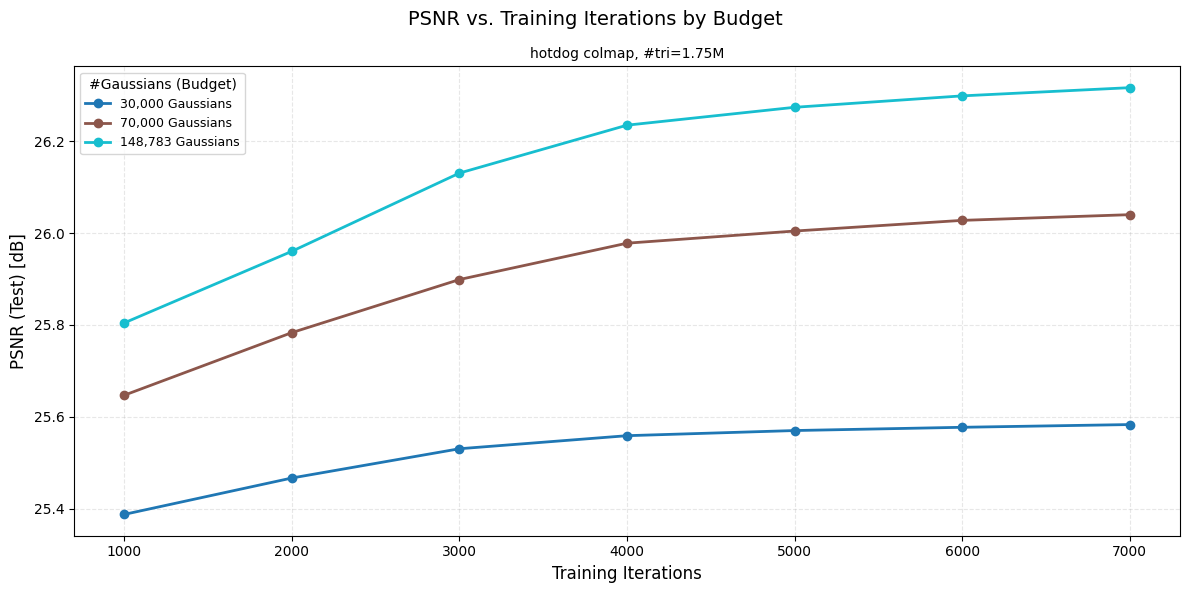

Figure saved to output/1114_hotdog_colmap/figure_policy/ssim_vs_iterations_by_budget.png


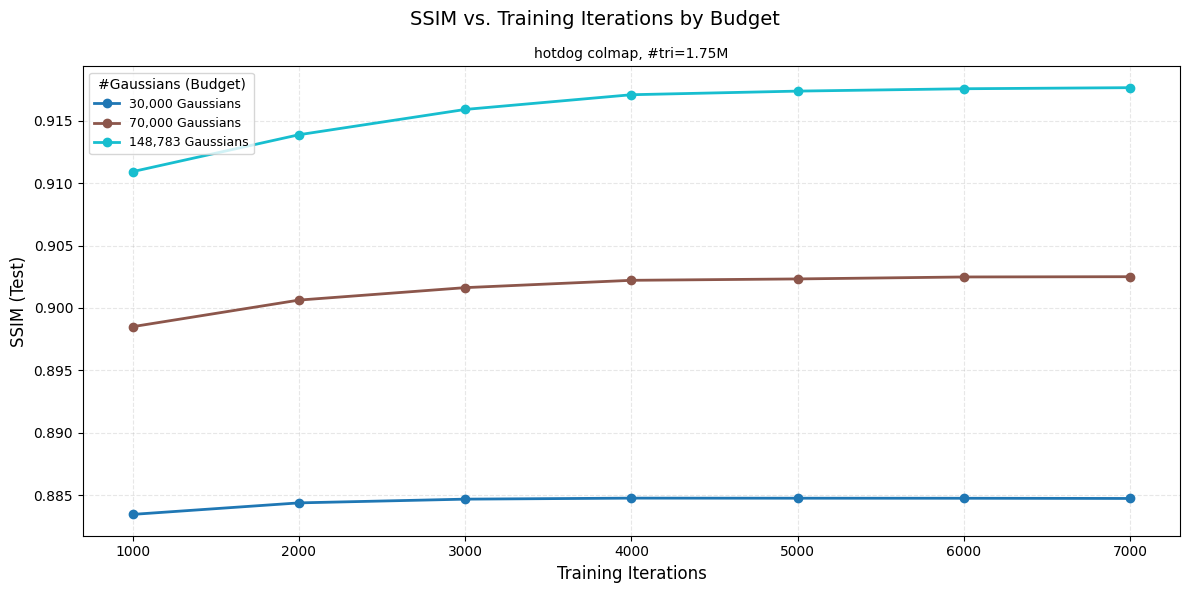

Figure saved to output/1114_hotdog_colmap/figure_policy/lpips_vs_iterations_by_budget.png


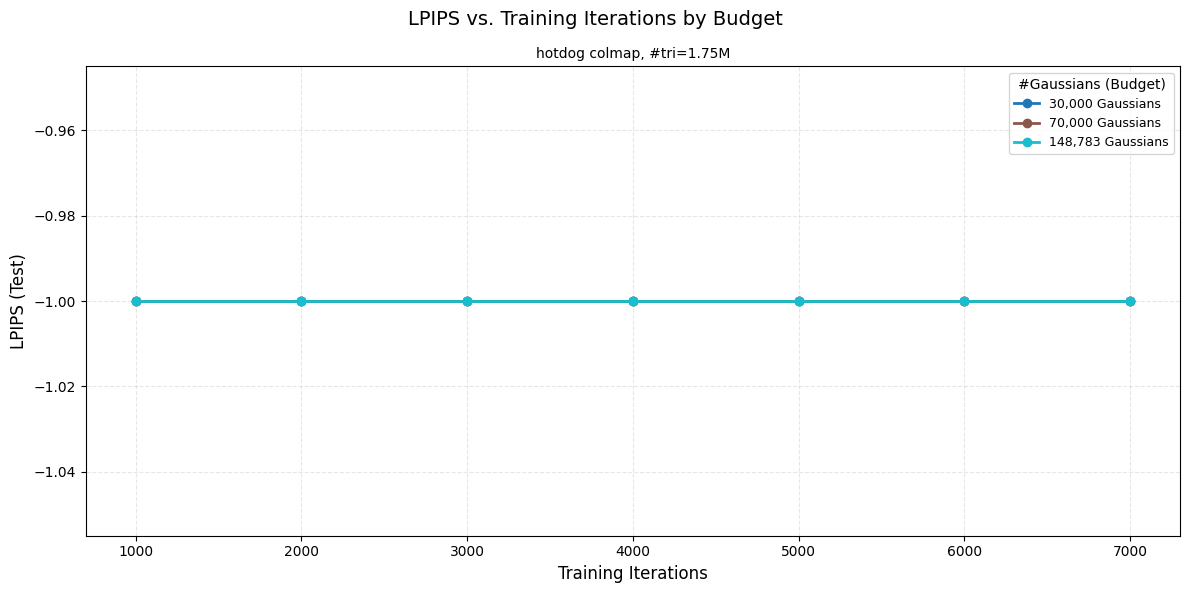

In [67]:
""" 3. Load and Plot Single Policy """

# --- Load aggregated data for a single policy ---
dtgs_json_path = Path(f'output/{EXPERIMENT_DATE}/figure_policy/')

if dtgs_json_path.is_dir():
    print(f"Loading aggregated data from: {dtgs_json_path}")
    json_files = sorted(glob(str(dtgs_json_path / '*_aggregated.json')))
    
    if json_files:
        # Load first policy as example
        policy_file = json_files[0]
        policy_name = Path(policy_file).name.replace('_aggregated.json', '')
        
        with open(policy_file, 'r') as f:
            policy_data = json.load(f)
        
        print(f"Loaded policy: {policy_name}")
        print(f"Iterations found: {sorted(policy_data.keys())}")
        
        # Plot single policy by iteration
        # plot_metrics_single_policy(
        #     policy_data=policy_data,
        #     policy_name=policy_name,
        #     scene_name=SCENE_NAME,
        #     num_iter=NUM_ITER,
        #     scene_size=SCENE_SIZE,
        #     output_dir=dtgs_json_path,
        #     draw_log_scale=False
        # )
        plot_metrics_by_budget(
            iter_data=policy_data,
            scene_name=SCENE_NAME,
            num_iter=NUM_ITER,
            mesh_type=MESH_TYPE,
            scene_size=SCENE_SIZE,
            output_dir=dtgs_json_path,
            draw_log_scale=False
        )
        
        
    else:
        print(f"No aggregated JSON files found in {dtgs_json_path}")
else:
    print(f"Directory not found: {dtgs_json_path}")

# before 1114  

## Data Aggregation

In [39]:
import os
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from matplotlib.ticker import FuncFormatter


NUM_ITER = 7000
SCENE_NAME = "hotdog"
SCENE_SIZE = "860K"  # in number of mesh faces

IS_AVG_BUDGET = False


EXPERIMENT_DATE = "1114_hotdog_sugar"



In [40]:
# --- 1. Data Collection and Aggregation ---

# Input directory containing the JSON files
input_dir = Path(f'output/{EXPERIMENT_DATE}/{SCENE_NAME}/for_plot')
# Output directory for aggregated JSONs and plots
output_dir_DTGS = Path(f'output/{EXPERIMENT_DATE}/figure_policy')
output_dir_TGS = Path(f'output/{EXPERIMENT_DATE}/figure_renderer')


output_dir_DTGS.mkdir(parents=True, exist_ok=True)
output_dir_TGS.mkdir(parents=True, exist_ok=True)


files = sorted(glob(str(input_dir / '*.json')))
# policy -> list of {num_gs, psnr, ssim, lpips}
policy_data = defaultdict(list)

print(f"Found {len(files)} files in {input_dir}")

for fp in files:
    try:
        # Extract policy and budget from filename like 'distortion_131072_occlusion.json'
        basename = os.path.basename(fp)
        stem = Path(basename).stem
        parts = stem.split('_')

        if "no_occlusion" in stem:
            # e.g., uniform_131072_no_occlusion
            policy_base = '_'.join(parts[:-3])
            budget_str = parts[-3]
            policy = f"{policy_base}_no_occ"
        else:
            # e.g., distortion_131072_occlusion
            policy_base = '_'.join(parts[:-2])
            budget_str = parts[-2]
            policy = f"{policy_base}_occ"

        # 1103 experiments use budget for average
        num_gs = float(budget_str)
        num_gs = num_gs * 835566 if IS_AVG_BUDGET else num_gs 
        num_gs = int(num_gs)
        
        

        with open(fp, 'r') as f:
            data = json.load(f)
        
        # The JSON has a structure like {"key": {"metric": value, ...}}
        # We get the first value from the top-level dictionary
        metrics = list(data.values())[0]
        
        psnr = metrics.get('PSNR')
        ssim = metrics.get('SSIM')
        lpips = metrics.get('LPIPS')

        if all(v is not None for v in [psnr, ssim, lpips]):
            policy_data[policy].append({
                "policy_name": policy,
                "num_gs": num_gs,
                "psnr": float(psnr),
                "ssim": float(ssim),
                "lpips": float(lpips)
            })
        else:
            print(f"Skipping {fp}: Missing one or more metrics.")

    except Exception as e:
        print(f"Error processing {fp}: {e}")

# --- 2. Save Aggregated Data to JSON Files ---

policies = sorted(policy_data.keys())
print(f"\nFound policies: {policies}")

for policy in policies:
    # Sort data by num_gs before saving
    sorted_data = sorted(policy_data[policy], key=lambda x: x['num_gs'])
    
    if "_no_occ" in policy:
        output_json_path = output_dir_TGS / f'{policy}_aggregated.json'
    else:
        output_json_path = output_dir_DTGS / f'{policy}_aggregated.json'
        
    with open(output_json_path, 'w') as f:
        json.dump(sorted_data, f, indent=2)
    print(f"Saved aggregated data to {output_json_path}")
    
# example shape
example_shape = (len(policy_data[policies[0]]),)
print(f"Example shape of aggregated data for policy '{policies[0]}': {example_shape}")


Found 11 files in output/1114_hotdog_sugar/hotdog/for_plot

Found policies: ['area_no_occ', 'area_occ', 'distortion_no_occ', 'distortion_occ', 'planarity_no_occ', 'random_no_occ', 'random_occ', 'uniform_occ']
Saved aggregated data to output/1114_hotdog_sugar/figure_renderer/area_no_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_policy/area_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_renderer/distortion_no_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_policy/distortion_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_renderer/planarity_no_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_renderer/random_no_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_policy/random_occ_aggregated.json
Saved aggregated data to output/1114_hotdog_sugar/figure_policy/uniform_occ_aggregated.json
Example shape of aggregated data fo

## Policy Comparison Charts

In [41]:

# # 1028 experiment
# WITH_OCC = False 
# aggregated_json_path = Path('output/exp1028_plots/')


# # 1027 experiment
# WITH_OCC = True 
# aggregated_json_path = Path('output/with_occ_json')

# 1029 experiment
WITH_OCC = True 
aggregated_json_path = Path(f'output/{EXPERIMENT_DATE}/figure_policy')



In [42]:

# [TODO] keep a fixed y-min (e.g. 26dB) across plots for policies, for better comparison
def autoset_ylim(ax, metric_key: str, values: 'list[float]') -> None:
    lo = min(values)
    hi = max(values)
    rng = max(hi - lo, 1e-9) 

    if metric_key.upper() == "PSNR":
        pad = max(0.15 * rng, 0.3)           # PSNR in dB 
        ax.set_ylim(lo - pad, hi + pad)

    elif metric_key.upper() == "SSIM":
        pad = max(0.25 * rng, 0.005)         # SSIM [0,1]
        ax.set_ylim(max(0.85, lo - pad), min(1.0, hi + pad))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))

    elif metric_key.upper() == "LPIPS":
        pad = max(0.25 * rng, 0.01)          # LPIPS [0,1]
        ax.set_ylim(max(0.0, lo - pad), min(0.6, hi + pad))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.2f}"))


def plot_metrics(policy_data, scene_name, num_iter, scene_size, output_dir, draw_log_scale=False):
    """
    Generates and saves plots for PSNR, SSIM, and LPIPS vs. Number of Gaussians.

    Args:
        policy_data (dict): A dictionary where keys are policy names and values are lists of metric records.
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plots.
        draw_log_scale (bool): Whether to use a log scale for the x-axis.
    """
    policies = sorted(policy_data.keys())
    
    metrics_to_plot = {
        "PSNR": {"unit": "dB", "label": "PSNR (Test) [dB]"},
        "SSIM": {"unit": "", "label": "SSIM (Test)"},
        "LPIPS": {"unit": "", "label": "LPIPS (Test)"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(policies)))

    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(8, 5))
        
        for policy, color in zip(policies, colors):
            records = policy_data.get(policy, [])
            if not records:
                continue

            # Sort by num_gs to ensure lines are drawn correctly
            records.sort(key=lambda r: r['num_gs'])
            
            xs = np.array([r['num_gs'] for r in records])
            ys = np.array([r[metric_key.lower()] for r in records])
            
            # Ensure positive x values for log scale
            xs_plot = np.maximum(xs, 1)
            
            marker = 'o'
            
            ax.plot(xs_plot, ys, marker=marker, linestyle='-', linewidth=2, markersize=5, 
                    color=color, label=policy.replace('_', ' ').title())
        
        
        ax.set_ylabel(metric_info["label"])
        fig.suptitle(f'{metric_key} vs. Number of Gaussians by Policy')
        ax.set_title(f'{scene_name} {scene_size} | NUM_ITER={num_iter} | WITH_DEPTH={WITH_OCC}', fontsize='small')
        
        ax.set_xlabel('#Gaussians')
        
        if draw_log_scale:
            try:
                ax.set_xscale('log', base=2)
                ax.set_xlabel('#Gaussians (log2 scale)')
            except TypeError:
                ax.set_xscale('log', basex=2)  # Fallback for older Matplotlib
        
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.legend(title='Policy')
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_vs_numgs_line_chart.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"\nFigure saved to {output_fig_path}")
        
        plt.show()


### result


Loading aggregated data from directory: output/1114_hotdog_sugar/figure_policy
  Loaded data for policy 'area_occ'
  Loaded data for policy 'distortion_occ'
  Loaded data for policy 'random_occ'
  Loaded data for policy 'uniform_occ'



Figure saved to output/1114_hotdog_sugar/figure_policy/psnr_vs_numgs_line_chart.png


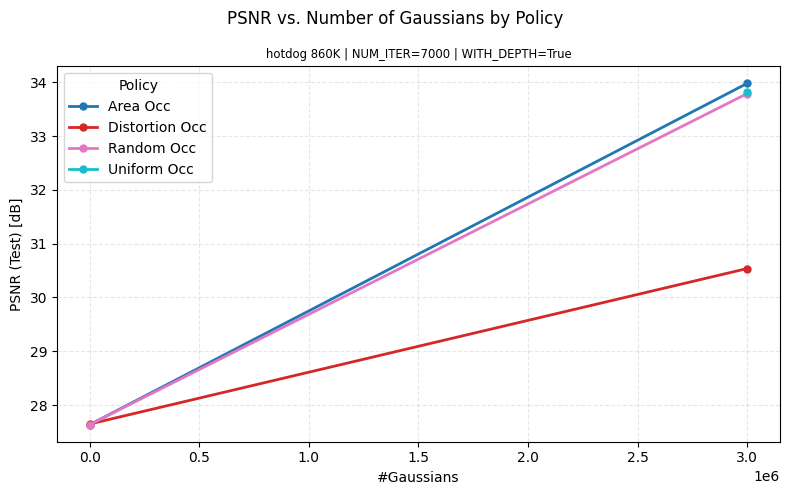


Figure saved to output/1114_hotdog_sugar/figure_policy/ssim_vs_numgs_line_chart.png


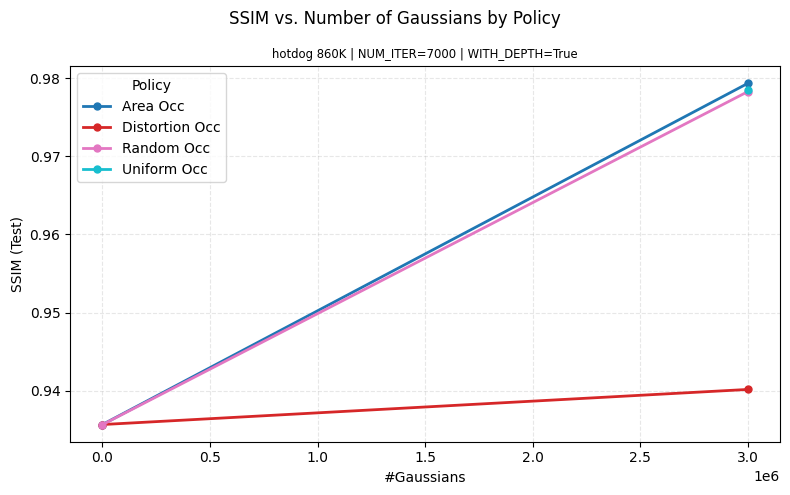


Figure saved to output/1114_hotdog_sugar/figure_policy/lpips_vs_numgs_line_chart.png


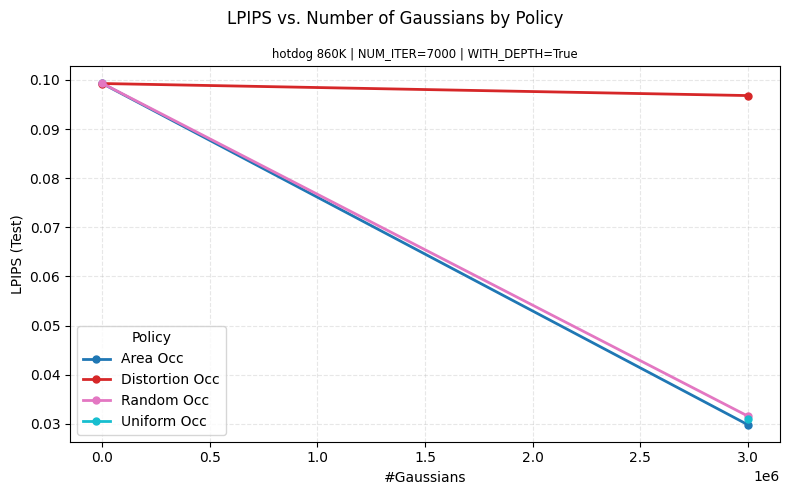

In [43]:
""" 3. Plotting """


# --- Plotting Logic ---

if aggregated_json_path and aggregated_json_path.is_dir():
    print(f"Loading aggregated data from directory: {aggregated_json_path}")
    data_to_plot = defaultdict(list)
    json_files = sorted(glob(str(aggregated_json_path / '*_aggregated.json')))
    
    if not json_files:
        print(f"No '*_aggregated.json' files found in {aggregated_json_path}")
        data_to_plot = None
    else:
        for file_path in json_files:
            try:
                policy_name = Path(file_path).name.replace('_aggregated.json', '')
                with open(file_path, 'r') as f:
                    loaded_data = json.load(f)
                
                if loaded_data:
                    data_to_plot[policy_name] = loaded_data
                    print(f"  Loaded data for policy '{policy_name}'")
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        output_dir = aggregated_json_path

elif 'policy_data' in locals() and policy_data:
    print("Using aggregated data from the previous cell.")
    data_to_plot = policy_data

if data_to_plot:
    plot_metrics(
        policy_data=data_to_plot,
        scene_name=SCENE_NAME,
        scene_size=SCENE_SIZE,
        num_iter=NUM_ITER,
        output_dir=output_dir,
        draw_log_scale=False
    )
else:
    print("\nNo data found to plot!")

### Target #GS (Budget) vs. Acutual Allocated #GS

## Occlusion Comparison Charts
compare rasterization with/without occlusion considered.


In [44]:
def plot_comparison_difference_line_chart(occ_data, vanilla_data, scene_name, num_iter, output_dir, draw_log_scale=False):
    """
    Generates line charts showing the difference (OCC - Vanilla) for each metric across all budgets.
    
    Args:
        occ_data (dict): Policy data with OCC enabled (keys ending with '_occ').
        vanilla_data (dict): Policy data without OCC (keys ending with '_no_occ').
        scene_name (str): The name of the scene for titles.
        num_iter (int): The number of iterations for titles.
        output_dir (Path): The directory to save the plots.
    """
    # Normalize policy names by removing suffixes
    def normalize_policy_name(name):
        """Remove _occ or _no_occ suffix to get base policy name."""
        if name.endswith('_no_occ'):
            return name[:-7]
        elif name.endswith('_occ'):
            return name[:-4]
        return name
    
    # Create mapping from base policy name to actual data
    occ_base_policies = {normalize_policy_name(k): k for k in occ_data.keys()}
    vanilla_base_policies = {normalize_policy_name(k): k for k in vanilla_data.keys()}
    
    # Find common base policies
    common_base_policies = sorted(set(occ_base_policies.keys()) & set(vanilla_base_policies.keys()))
    
    if not common_base_policies:
        print("No common policies found!")
        print(f"OCC policies: {list(occ_base_policies.keys())}")
        print(f"Vanilla policies: {list(vanilla_base_policies.keys())}")
        return
    
    print(f"Found {len(common_base_policies)} common policies: {common_base_policies}")
    
    metrics_to_plot = {
        "PSNR": {"label": "PSNR Difference (With OCC - Without OCC) [dB]"},
        "SSIM": {"label": "SSIM Difference (With OCC - Without OCC)"},
        "LPIPS": {"label": "LPIPS Difference (With OCC - Without OCC)"}
    }
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(common_base_policies)))

    for metric_key, metric_info in metrics_to_plot.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for base_policy, color in zip(common_base_policies, colors):
            # Get the actual policy keys
            occ_key = occ_base_policies[base_policy]
            vanilla_key = vanilla_base_policies[base_policy]
            
            occ_records = sorted(occ_data.get(occ_key, []), key=lambda r: r['num_gs'])
            vanilla_records = sorted(vanilla_data.get(vanilla_key, []), key=lambda r: r['num_gs'])
            
            # Create dictionaries for quick lookup
            occ_budgets = {r['num_gs']: r[metric_key.lower()] for r in occ_records}
            vanilla_budgets = {r['num_gs']: r[metric_key.lower()] for r in vanilla_records}
            
            common_budgets = sorted(set(occ_budgets.keys()) & set(vanilla_budgets.keys()))
            
            if not common_budgets:
                print(f"Warning: No common budgets for policy '{base_policy}'")
                continue
            
            # Calculate differences
            differences = [occ_budgets[b] - vanilla_budgets[b] for b in common_budgets]
            
            # Plotting
            ax.plot(common_budgets, differences, marker='o', linestyle='-', 
                    label=base_policy.replace('_', ' ').title(), color=color)

        # Add a horizontal line at y=0 for reference
        ax.axhline(0, color='grey', linestyle='--', linewidth=1)
        
        # Customize plot
        ax.set_ylabel(metric_info["label"], fontsize=12)
        ax.set_xlabel('#Gaussians', fontsize=12)
        fig.suptitle(f'{metric_key} Difference: DTGS vs. TGS', fontsize=14, fontweight='bold')
        ax.set_title(f'{scene_name} | NUM_ITER={num_iter} | D = Depth, T = Texture', fontsize=10)
        
        
        if draw_log_scale:
            try:
                ax.set_xscale('log', base=2)
                ax.set_xlabel('#Gaussians (log2 scale)')
            except TypeError:
                ax.set_xscale('log', basex=2)  # Fallback for older Matplotlib
        
        ax.legend(title='Policy', loc='best')
        ax.grid(True, which="both", ls="--", alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        output_fig_path = output_dir / f'{metric_key.lower()}_difference_line_chart.png'
        plt.savefig(output_fig_path, dpi=200, bbox_inches='tight')
        print(f"Figure saved to {output_fig_path}")
        
        plt.show()

### result

Loaded OCC data for policy 'area_occ'
Loaded OCC data for policy 'distortion_occ'
Loaded OCC data for policy 'random_occ'
Loaded OCC data for policy 'uniform_occ'
Loaded vanilla data for policy 'area_no_occ'
Loaded vanilla data for policy 'distortion_no_occ'
Loaded vanilla data for policy 'planarity_no_occ'
Loaded vanilla data for policy 'random_no_occ'

--- Plotting difference line chart ---
Found 3 common policies: ['area', 'distortion', 'random']


Figure saved to output/1114_hotdog_sugar/figure_renderer/psnr_difference_line_chart.png


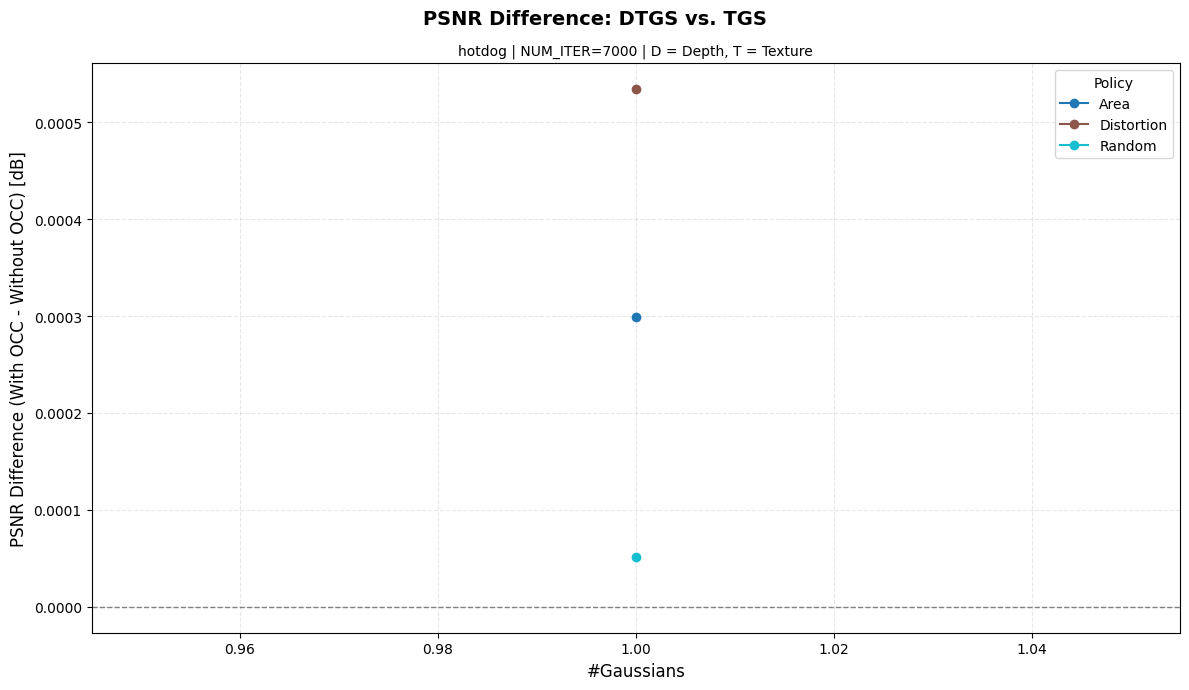

Figure saved to output/1114_hotdog_sugar/figure_renderer/ssim_difference_line_chart.png


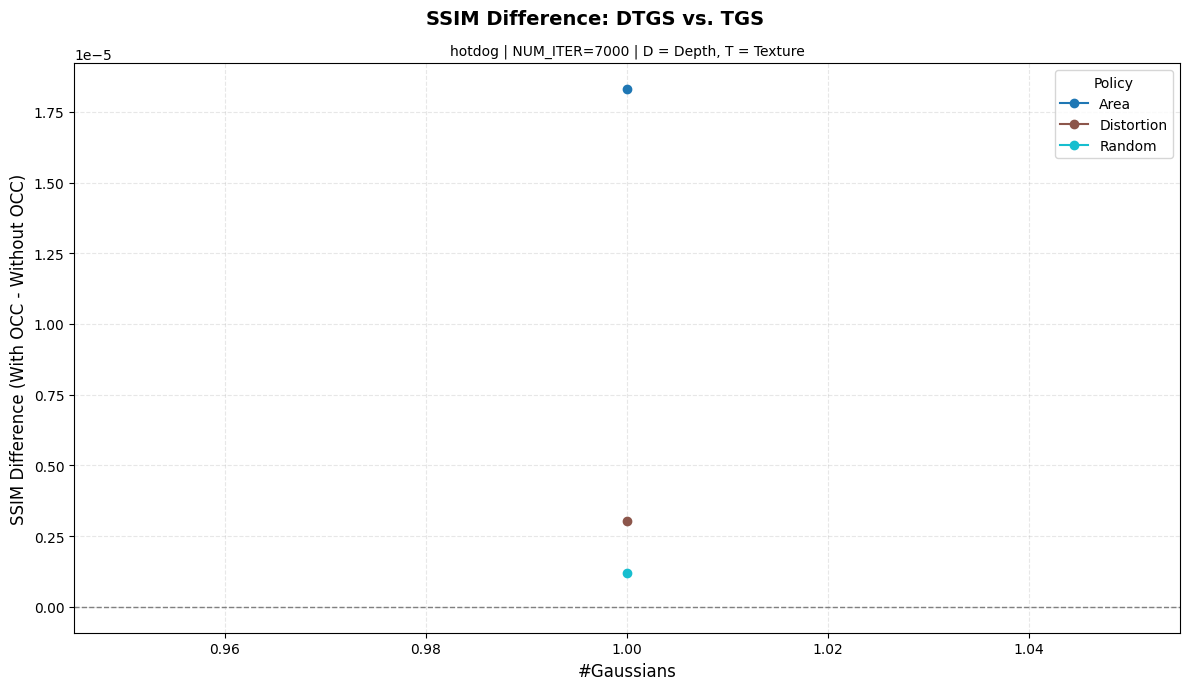

Figure saved to output/1114_hotdog_sugar/figure_renderer/lpips_difference_line_chart.png


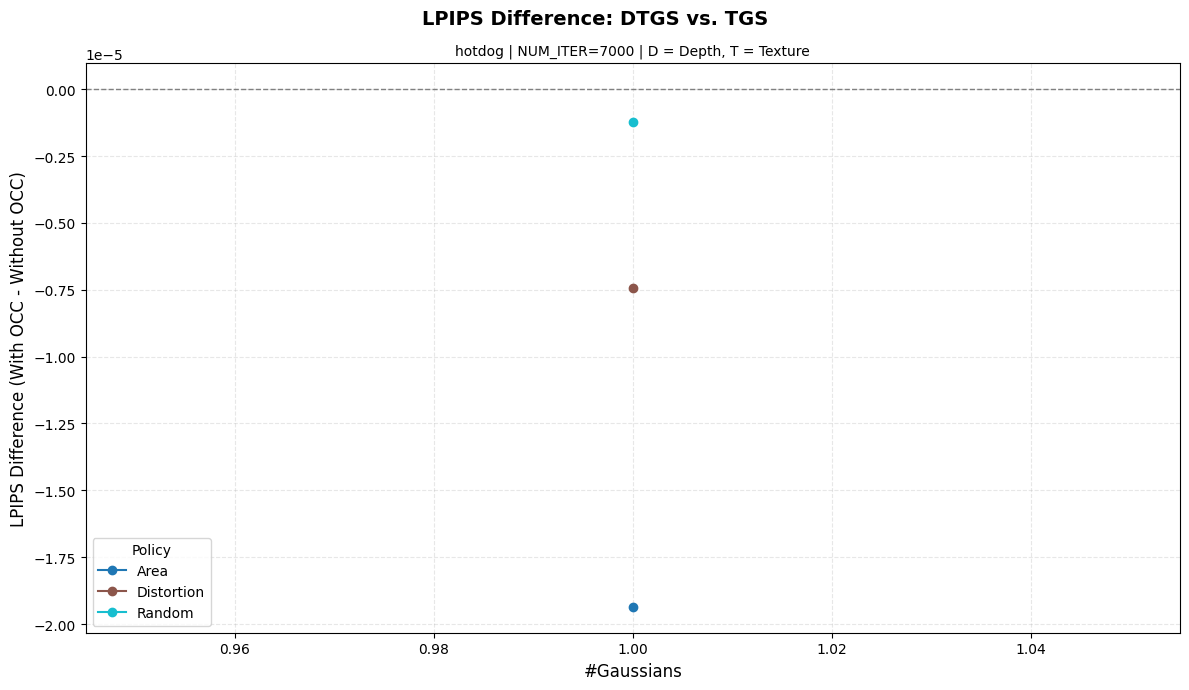

In [45]:


dtgs_json_path = Path(f'output/{EXPERIMENT_DATE}/figure_policy/')
tgs_json_path = Path(f'output/{EXPERIMENT_DATE}/figure_renderer')

""" Load data and plot comparisons """

# Load OCC data
occ_data_dict = defaultdict(list)
occ_json_files = sorted(glob(str(dtgs_json_path / '*_aggregated.json')))
for file_path in occ_json_files:
    policy_name = Path(file_path).name.replace('_aggregated.json', '')
    with open(file_path, 'r') as f:
        occ_data_dict[policy_name] = json.load(f)
    print(f"Loaded OCC data for policy '{policy_name}'")

# Load vanilla data
vanilla_data_dict = defaultdict(list)
vanilla_json_files = sorted(glob(str(tgs_json_path / '*_aggregated.json')))
for file_path in vanilla_json_files:
    policy_name = Path(file_path).name.replace('_aggregated.json', '')
    with open(file_path, 'r') as f:
        vanilla_data_dict[policy_name] = json.load(f)
    print(f"Loaded vanilla data for policy '{policy_name}'")

# Create output directory for comparison plots
comparison_output_dir = Path(f'output/{EXPERIMENT_DATE}/figure_renderer')
comparison_output_dir.mkdir(parents=True, exist_ok=True)



# Plot comparison as a difference line chart
print("\n--- Plotting difference line chart ---")
plot_comparison_difference_line_chart(
    occ_data=occ_data_dict,
    vanilla_data=vanilla_data_dict,
    scene_name=SCENE_NAME,
    num_iter=NUM_ITER,
    output_dir=comparison_output_dir
)

